# KNN y Clasificación

En esta clase vamos a aprender sobre K-nearest neighbors, una herramienta de clasificación. Además, vamos a aprender cómo medir el desempeño de un modelo clasificador. 

- Clasificación binaria
- Medidas de desempeño
- Clasificación multiclase

## KNN

KNN, o *k-nearest neighbors*, es un modelo qe nos permite hacer tanto clasificación como regresión, y lo hace de una forma completamente distinta a las regresiones lineal y logística. 

Para KNN, lo que nosotros vamos a querer hacer normalmente es entrenar un modelo que nos pueda predecir ya sea una clase (clasificación) o un valor (regresión) de nuevas observaciones. Asumiendo que tenemos una métrica de distancia $d$, y conjunto $(X,Y)$, en donde $X$ representa un conjunto de punto en un espacio métrico que usa $d$, e $Y$ los valores conocidos de los puntos en $X$, el algoritmo de KNN funciona de la siguiente forma. Para una nueva observación $x$, el valor que predice KNN para $x$ se define como: 
- Si el problema es de clasificación, entonces $x$ es asignado a la clase al que pertenecen la mayoría de los $k$ puntos de $X$ más cercanos a $x$ (de acuerdo a la distancia $d$).
- Si el problema es de regresión, entonces el valor predicho para $x$ es el promedio del valor de los $k$ puntos de $X$ más cercanos a $x$ (de acuerdo a la distancia $d$).  


Vamos a empezar entendiendo que pasa con KNN y los helados. Como los valores de female, video y puzzle son números, usamos la distancia euclideana (que es la distancia por defecto de la librería sklearn). 

In [1]:
import pandas as pd
helados = pd.read_csv('Ice_cream.csv')
helados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  200 non-null    int64
 1   id          200 non-null    int64
 2   female      200 non-null    int64
 3   ice_cream   200 non-null    int64
 4   video       200 non-null    int64
 5   puzzle      200 non-null    int64
dtypes: int64(6)
memory usage: 9.5 KB


In [2]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(helados[['video','puzzle']], helados['ice_cream'])

KNeighborsClassifier(n_neighbors=3)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


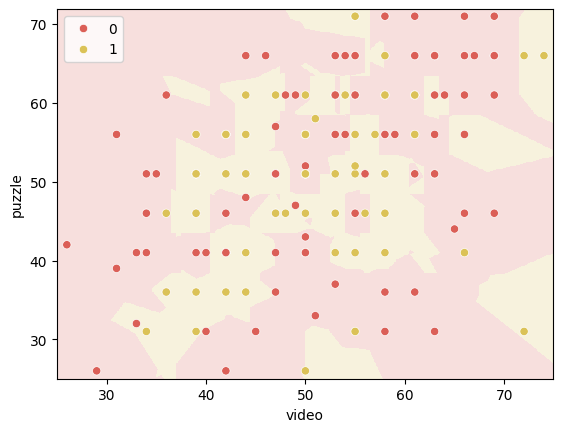

In [3]:
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

palette = sns.color_palette("hls", 8)
# Pasamos la paleta a Hexadecimal
# Para el fondo necesitamos que sea un Colormap
palete_hex = palette.as_hex()
palette_back = ListedColormap(palete_hex[0:2])

# Límites del gráfico
# Buscamos los límites del gráfico
x_min, x_max = helados.video.min() - 1, helados.video.max() + 1
y_min, y_max = helados.puzzle.min() - 1, helados.puzzle.max() + 1

# Generamos las combinaciones de x/y del plano en los rangos
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Generamos las predicciones
predictions = neigh.predict(np.c_[xx.ravel(), yy.ravel()])

# Resultado de la frontera de decisión con color claro
Z = predictions.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=palette_back, shading='auto', alpha=0.2)
plt.xlabel('video')
plt.ylabel('puzzle')

sns.scatterplot(data=helados, x="video", y="puzzle", hue="ice_cream", palette=palette[0:2])

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.legend()

plt.show()


Nada que ver con la regresión, este modelo es cualqier cosa menos lineal. Para este dataset en particular, parece ser que KNN es mucho mejor. Veamos el log-loss, va a dar mucho más bajo que con la regresión. 

In [4]:
from sklearn.metrics import log_loss

predictions = neigh.predict(helados[['video','puzzle']])
log_loss(helados['ice_cream'],predictions)

9.010913347279288

Hemos visto sobre el log loss, pero hay medidas mejores. La primera: por qué no contamos simplemente a cuanto le achuntamos y cuanto no?

Evidentemente, esto hace más sentido en un entorno de cross validation. 

Vamos a entrenar dos clasificadores: KNN usando **video** y **puzzle** y otro que agregue **female**.  

In [5]:
neigh_pv = KNeighborsClassifier(n_neighbors=3)
neigh_pv.fit(helados[['video','puzzle']], helados['ice_cream'])

neigh_pvf = KNeighborsClassifier(n_neighbors=10)
neigh_pvf.fit(helados[['female','video','puzzle']], helados['ice_cream'])

KNeighborsClassifier(n_neighbors=10)

Ahora usamos una función que nos hace el cross-validation de forma automatica. El scoring que pedimos es accuracy. 

> Accuracy: # de entidades bien clasificadas / # de datos totales

In [6]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(neigh_pv, helados[['video','puzzle']], helados['ice_cream'], cv=3, scoring='accuracy'))

print(cross_val_score(neigh_pvf, helados[['female','video','puzzle']], helados['ice_cream'], cv=3, scoring='accuracy'))

[0.40298507 0.50746269 0.46969697]
[0.50746269 0.49253731 0.54545455]


## Ejercicio: experimenta con distintos valores de k para KNN, ¿qué pasa con el accuracy?

In [7]:
## Crearé una función que repite el proceso para distintos k y retorna el promedio de los valores

def trying_neightbors(k, X, y):
    actual = KNeighborsClassifier(n_neighbors=k)
    actual.fit(X,y)
    actual.predict(X)
    return sum(cross_val_score(actual, X, y, cv=3, scoring='accuracy'))/3


results = []

# Aquí revisamos entre 1 y 100 vecinos
for i in range(1, 101):
    results.append((i, trying_neightbors(i, helados[['video','puzzle']], helados['ice_cream'])))


El valor con el mayor accuracy es 0.5401778983868536 
cuando tiene 5 vecinos


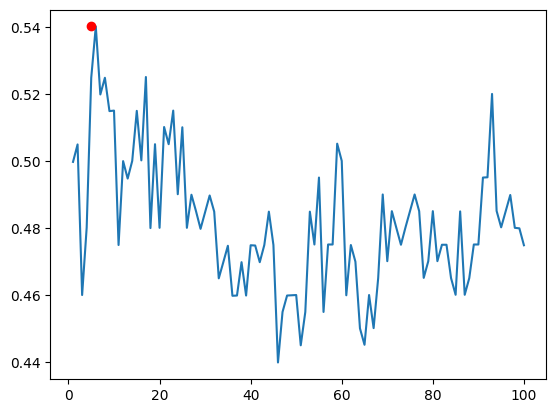

In [8]:
# Creamos un gráfico para ver como actua con más vecinos
import matplotlib.pyplot as plt

x_val = [x[0] for x in results]
y_val = [float(x[1]) for x in results]

plt.plot(x_val,y_val)
plt.plot(y_val.index(max(y_val)), max(y_val),'or')

print(f"El valor con el mayor accuracy es {max(y_val)} \ncuando tiene {y_val.index(max(y_val))} vecinos")

# Medidas de desempeño para clasificadores binarios: Precision, Recall, matriz de confusión

Para mostrar empíricamente qué pasa con el accuracy y por qué es necesario considerar mejores medidas, nos vamos a pasar a un dataset más complejo. 

Este dataset tiene miles de ejemplos de scans de números escritos a mano (son 784 pixeles). La tarea es clasificar los números. 



In [9]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=True)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [10]:
import pandas as pd
X = mnist['data'] 
y = mnist['target']

# Vamos a trabajar con datos mas chicos
X, y = X[:60000], y[:60000]

In [11]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Para trabajar primero con clasificación binaria, vamos a cambiar el y por un arreglo que tenga true cuando es un 7 y false cuando no. 


In [12]:
y = y.astype(int)
y_7 = (y == 7)
y_7

0        False
1        False
2        False
3        False
4        False
         ...  
59995    False
59996    False
59997    False
59998    False
59999    False
Name: class, Length: 60000, dtype: bool

 El valor es muy alto, ¡deberíamos estar felices!, pero ¿esta es realmente una buena medida para entender nuestro modelo? Vamos a discutir esto en la siguiente sección.

## Medidas de desempeño

Vamos a hacer un ejercicio bastante sencillo. Vamos a hacer un clasificador que siempre nos diga que **no estamos viendo un 7** y vamos a medir su desempeño.

In [13]:
from sklearn.base import BaseEstimator

class Never7Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

En el ejemplo anterior estamos definiendo nuestro propio modelo, que contesta `False` siempre. Vemos además que es muy fácil hacer nuestros propios clasificadores. 

Ahora bien, antes de continuar, ¿puedes adivinar el desempeño que va a tener este clasificador?

In [14]:
n7_clf = Never7Classifier()
cross_val_score(n7_clf, X, y_7, cv=3, scoring='accuracy')

array([0.89535, 0.8984 , 0.893  ])

Así es, cerca de 90% para un muy mal clasificador. Esto no nos sorprende, porque cerca del 10% de los elementos del dataset son un 7. Esto nos muestra por qué _Accuracy_ no es una buena medida de desempeño, especialmente cuando algunas clases aparecen poco: un clasificador que nunca prediga esas clases se debería comportar siempre relativamente bien. Por lo mismo, vamos a medir el desempeño de una mucho mejor forma: la matriz de confusión (_Confusion Matrix_).

### Matriz de confusión

En una matriz de confusión tenemos una fila que representa la clase que estamos analizando y una columna para cada clase predicha para las instancias de la fila. Veamos cómo se ve en nuestro ejemplo.

Vamos ahora por la matriz de confusión.

In [15]:
from sklearn.metrics import confusion_matrix
ypred = n7_clf.predict(X)
confusion_matrix(y_7, ypred)

array([[53735,     0],
       [ 6265,     0]])

Recordemos que la clase 0 significa "no es 7", y la clase 1 significa "es un 7". Así que la fila 0 nos dice que 53500 instancias que tenían la clase 0, fueron clasificadas como clase 0, mientras que 235 instancias de clase 0 fueron clasificadas como clase 1. Mientras tanto, la fila 1 nos dice que 175 instancias que eran de la clase 1 fueron clasificadas como clase 0 y 6090 instancias de clase 1 fueron clasificadas correctamente. Vamos ahora cómo se comporta nuestro clasificador que siempre responde falso.

In [16]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(n7_clf, X, y_7, cv=3)
confusion_matrix(y_7, y_pred)

array([[53735,     0],
       [ 6265,     0]])

Como es de esperar, acerto en todos las instancias que no son 7, y se equivocó en todas las que son 7. Así, un clasificador perfecto tiene números  solamente en la diagonal, y en todos los demás casilleros hay 0s. Gracias a la matriz de confusión, tenemos una medida objetiva de que este modelo es malo, a pesar de su buen _accuracy_.

### _Precision_ y _Recall_

Si bien la matriz de confusión nos entrega varios valores (si tenemos más clases son muchas más filas y columnas!) a veces queremos algo más concreto. Dos medidas bastante famosas son _Precision_ y _Recall_. Vamos a presentarlas a continuación.


$$
\text{precision} = \frac{TP}{TP + FP}
$$

$$
\text{recall} = \frac{TP}{TP + FN}
$$

En donde $TP$ son los verdaderos positivos (_True Possitive_), $FP$ son los falsos positivos (_False Possitives_) y $FN$ los falsos negativos (_False Negatives_).

¿Por qué necesitamos dos valores? La respuesta la podemos entender con el siguiente ejemplo: supón que tenemos un modelo que solamente clasifica un elemento de forma correcta, pero está muy seguro de lo que hace. Así, los falsos positivos serán 0 y la precisión será $1/1$, que equivale al 100%. Así podemos entender la precisión como **cuando digo que algo es de una clase, qué porcentaje de las veces estoy en lo correcto** y el _recall_ como **de los positivos que existen, cuantos estoy detectando**. Veamos esta medida en nuestro clasificador de 7s.

Así, vemos que nuestro clasificador no está "realmente seguro" cuando dice que algo es un 7, mientras que sí detecta la mayoría de los 7. También existe otro puntaje en el que no vamos a hacer énfasis, pero es el $F_1$ _score_, que es la media armónica entre _Precision_ y _Recall_:

$$
F_1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
$$

Que es una medida que beneficia a modelos con precisión y _recall_ similares. Pero a veces queremos modelos que beneficien la precisión o el _recall_. Pensemos en los siguientes casos:

- Queremos hacer un modelo que nos diga si ciertos medicamentos son seguros para la salud. Aquí nos interesa estar realmente seguros de si un medicamento es clasificado como seguro (positivo), a pesar de que podamos tener muchos falsos negativos. Aquí queremos altra precisión, a un costo de bajo _recall_.
- Queremos hacer un modelo que recomiende canciones a alguien. Quizás no nos importa equivocarnos a cambio de que todas las posibles canciones que le gustan a la persona sean recomendadas. Aquí tendremos varios falsos positivos, por lo que habrá una baja precisión, pero tendremos un alto _recall_, porque el objetivo era tener pocos falsos negativos.

Usualmente nos encontraremos con un _trade-off_ entre precisión y _recall_.

## Ejercicio 2

Entrena un clasificador de regresión logística para este problema. 

Reproduce la matriz de confusión y compara con el clasificador de 3NN. ¿Cuál clasificador es mejor? ¿Cómo se comporta la regresión logística en cuanto a precision y recall? 

Vamos a trabajar con un set de datos mas chicos, para que la regresión logística converga en un intervalo de tiempo razonable


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score

Xchico = X[:5000]
Ychico = y_7[:5000]
reg = LogisticRegression(max_iter = 2000)
reg.fit(Xchico, Ychico)
R_predict = reg.predict(Xchico)


nn3 = KNeighborsClassifier(n_neighbors=3)
nn3.fit(Xchico, Ychico)
N_predict = nn3.predict(Xchico)

confusion_matrix(R_predict, Ychico), confusion_matrix(N_predict, Ychico)


(array([[4450,    0],
        [   0,  550]]),
 array([[4438,   14],
        [  12,  536]]))

Vemos que segun las matrices, es mejor predecir con la regresión lineal porque no hay negativos ni positivos falsos

In [18]:
print(f"El recall para la regresión lineal es: {recall_score(R_predict, Ychico)}\nEl recall para el NN3 es: {recall_score(N_predict, Ychico)}")


El recall para la regresión lineal es: 1.0
El recall para el NN3 es: 0.9781021897810219


In [19]:
print(f"La presición para la regresión lineal es: {precision_score(R_predict, Ychico)}\nLa presición para el NN3 es: {precision_score(N_predict, Ychico)}")

La presición para la regresión lineal es: 1.0
La presición para el NN3 es: 0.9745454545454545


: 

Vemos que el recall y la presición es mejor en ambos caso para la regresión lineal

## Clasificación multiclase y KNN

Supongamos que ahora no queremos saber si algo es o no es un 7, sino que queremos saber qué número es. Con lo que sabemos hasta ahora, ¿cómo lo podemos hacer?

KNN nos da soporte natural para clasificación multiclase, y hay también modelos de regresión logística para esto. 

Veamos que pasa con un 3NN para el caso multiclase. 

In [20]:
neigh_numbers = KNeighborsClassifier(n_neighbors=3)

cross_val_score(neigh_numbers, X, y, cv=3, scoring='accuracy')

Estos son muy buenos puntajes, porque en este caso un clasificador _random_ tendría cerca del 10% de _accuracy_. Sin embargo, es una buena idea revisar la matriz de confusión para este escenario.

In [ ]:
y_pred = cross_val_predict(neigh_numbers, X, y, cv=3)
conf_mx = confusion_matrix(y, y_pred)
conf_mx

Ahora bien, dado que tenemos muchos números, lo mejor es ver esto como una imagen. En esta imagen en escala de grises veremos para cada fila el número de instancias que son del número representado por esa clasificadas en cada columna. Mientras más instancias caen en un determinado casillero, más blanco el casillero. El casillero con el menor valor se lleva el color negro, y el de mayor valor el color blanco.

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Ahora nos queremos concentrar en los errores, así que vamos a hacer lo siguiente:

- Primero, vamos a setear en 0 la diagonal para que no nos entregue ruido.
- Segundo, vamos a normalizar cada fila. Esto es sumar los valores de cada fila, y dividir todos los elementos de esa fila por el valor. Esto se hace porque una clase muy grande se puede ver mal en comparación a otras, pero si lo miramos como _ratio_, puede no ser así.

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Aquí podemos ver, por ejemplo, que hay muchos 4 que se confunden por 9. ¿Qué más puedes ver? 

*Respuesta:* Puedo ver que los 8 también se confunden con los 5 y que la predición sobre cada número no es correcto. 